Strategy with CatBoost regression model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import StandardScaler
from arch import arch_model
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import RidgeCV

In [2]:
def read_data(ticker):
    """
    Read logarithmic returns from file

    :ticker: ticker of continious futures
    """
    # You need to insert the path to the data file
    data = pd.read_csv(ticker+'.csv', index_col = 'date')
    #All datasets for this course are available at this link:
    #https://drive.google.com/drive/folders/1mhbVjuwNZGX9nmZuCxJStBmraF3HIzio?usp=sharing

    # Parse timestamps
    data.index = pd.to_datetime(data.index, format = "%Y-%m-%d %H:%M:%S")

    return data

In [2]:
es = pd.read_csv('ES.csv', parse_dates=['date'])
es = es.set_index('date').sort_index()
es_4h = es['log_ret'].resample('4h').sum().to_frame('log_ret')
es_4h['log_ret'].value_counts()
data_es = es_4h.loc[~(es_4h['log_ret'] == 0)].copy()

In [3]:
gc = pd.read_csv('GC.csv', parse_dates = ['date'])
gc = gc.set_index('date').sort_index()
gc_4h = gc['log_ret'].resample('4h').sum().to_frame('log_ret')
gc_4h['log_ret'].value_counts()
data_gc = gc_4h.loc[~(gc_4h['log_ret'] == 0)].copy()

In [4]:
df = pd.read_csv('NQ.csv', parse_dates=['date'])
df = df.set_index('date').sort_index()
df_4h = df['log_ret'].resample('4h').sum().to_frame('log_ret')
data = df_4h.loc[~(df_4h['log_ret'] == 0)].copy()

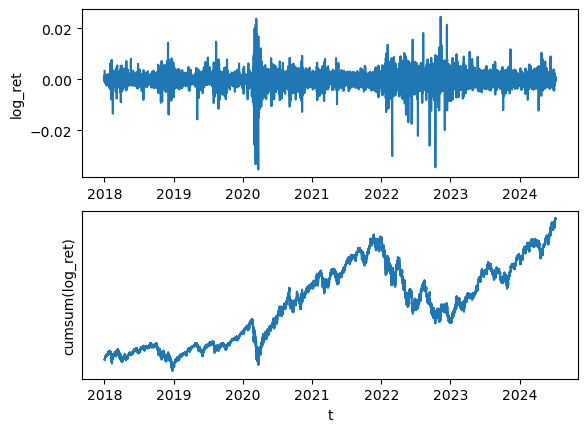

In [ ]:
# Let's draw graphs
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(data)
ax1.set_ylabel('log_ret')

ax2.plot(data.cumsum())
ax2.set_yticks([])
ax2.set_ylabel('cumsum(log_ret)')
_ = ax2.set_xlabel('t')

In [5]:
days_in_year = 365.25

def Return(rets):
    """
    Annual return estimate

    :rets: daily returns of the strategy
    """
    return np.mean(rets)*days_in_year


def Volatility(rets):
    """
    Estimation of annual volatility

    :rets: daily returns of the strategy
    """
    return np.std(rets)*np.sqrt(days_in_year)


def SharpeRatio(rets):
    """
    Estimating the annual Sharpe ratio

    :rets: daily returns of the strategy
    """
    volatility = Volatility(rets)
    if (volatility>0):
        return Return(rets)/volatility
    else:
        return float('NaN')

def statistics_calc(rets, bh, name = '_', plot = False):
    """
    Draws a graph of portfolio equity and calculates annual Sharpe ratios, profitability and volatility

    :rets: daily returns of the strategy
    """
    sharpe = SharpeRatio(rets)
    ret = Return(rets)
    vol = Volatility(rets)
    if plot:
        plt.plot(rets.cumsum(), label = 'strategy')
        plt.plot(bh.cumsum(), label = 'buy & hold')
        plt.xlabel('t')
        plt.legend()
        print('Sharpe ratio = %0.2f'%sharpe)
        print('Annual Return = %0.2f'%ret)
        print('Annual Std = %0.2f'%vol)
    return  pd.DataFrame([[sharpe, ret, vol]], columns = ['Sharpe ratio', 'Annual return', 'Volatility'], index = [name])

Features generation:

In [6]:
def make_features(data, pref = ''):
    features = pd.DataFrame(index = data.index)

    features['sign'] = np.sign(data['log_ret']).shift(1)
    # Estimating asset volatility using double exponential moving average:
    features['absRet'] = np.abs(data['log_ret'])
    features['EmaAbsRet'] = features['absRet'].ewm(20).mean().shift(1)*np.sqrt(20)
    features['vol'] = features['EmaAbsRet'].ewm(200).mean()*np.sqrt(200)+0.000000001

    features['normalized_log_ret'] = data['log_ret'].shift(1)/features['vol']

    periods = (np.logspace(1.0, 3.0, num = 10)).astype(int)
    print(periods)

    for period in periods:
        features['f_'+pref+str(period)] = (np.sqrt(period)*features['normalized_log_ret'].rolling(window = period, win_type = 'hann').mean()).shift(1)
    features = features.dropna()

    features['gc'] = data_gc['log_ret']
    features['es'] = data_es['log_ret']


    for lag in [1, 3, 5, 10]:
        features[f'lag_{lag}'] = data['log_ret'].shift(lag)
        features[f'gc_lag_{lag}'] = features['gc'].shift(lag)
        features[f'es_lag_{lag}'] = features['es'].shift(lag)

    features['std_3']  = data['log_ret'].rolling(3).std().shift(1)

    am = arch_model(data['log_ret'] * 100, vol='GARCH', p=1, q=1, dist='normal')
    res = am.fit(disp='off')
    features['garch_vol'] = res.conditional_volatility.shift(1) / 100

    P = 24/4  
    t = np.arange(len(features))
    features['sin_2pi_t_P'] = np.sin(2 * np.pi * t / P)
    features['cos_2pi_t_P'] = np.cos(2 * np.pi * t / P)

    # features['lag1_x_garch']  = features['lag_1'] * features['garch_vol']
    # features['es_x_gc'] = features['es_lag_1']  * features['gc_lag_1']
    # regime = (features['std_3'] > features['std_3'].median()).astype(int)
    # features['regime_x_sign'] = regime * features['sign']

    return features.dropna()

In [7]:
features =  make_features(data)
# features2 = make_features(data2, pref = 's')
# features2 = features2[features2.columns[np.array([name[:2] for name in features.columns]) == 'f_']]
# features = features.merge(features2, how = 'left', left_index = True, right_index = True).ffill()

[  10   16   27   46   77  129  215  359  599 1000]


In [ ]:
y = features['normalized_log_ret'].values
X = features[features.columns[np.array([name[:2] for name in features.columns]) == 'f_']].values

# This is another way to specify training and training periods
train_split_idx = int(0.4*X.shape[0])
validation_split_idx = int(0.7*X.shape[0])

features_train = features[:train_split_idx].copy()

X_train = X[:train_split_idx]
y_train = y[:train_split_idx]

X_validation = X[train_split_idx:validation_split_idx]
y_validation = y[train_split_idx:validation_split_idx]
features_validation = features[train_split_idx:validation_split_idx].copy()

X_test = X[validation_split_idx:]
y_test = y[validation_split_idx:]

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition   import PCA

import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition    import PCA

# 1) удаляем признаки с нулевой дисперсией
vt = VarianceThreshold(threshold=0.0)
X_train      = vt.fit_transform(X_train)
X_validation = vt.transform(X_validation)
X_test       = vt.transform(X_test)

# 2) вручную стандартируем (subtract mean, divide by std+eps)
means = X_train.mean(axis=0)
stds  = X_train.std(axis=0)
eps   = 1e-8
stds  = np.where(stds < eps, 1.0, stds)    # все слишком малые => 1.0

X_train      = (X_train      - means) / stds
X_validation = (X_validation - means) / stds
X_test       = (X_test       - means) / stds

# 3) затираем NaN и бесконечности
X_train      = np.nan_to_num(X_train,      nan=0.0, posinf=0.0, neginf=0.0)
X_validation = np.nan_to_num(X_validation, nan=0.0, posinf=0.0, neginf=0.0)
X_test       = np.nan_to_num(X_test,       nan=0.0, posinf=0.0, neginf=0.0)

# 4) наконец PCA
pca = PCA(n_components=10)   # или другое число
X_train      = pca.fit_transform(X_train)
X_validation = pca.transform(X_validation)
X_test       = pca.transform(X_test)


train_pool = Pool(data = X_train,
                  label = y_train)

/Users/ekaterinakorshik/Documents/code/venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ekaterinakorshik/Documents/code/venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ekaterinakorshik/Documents/code/venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ekaterinakorshik/Documents/code/venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ekaterinakorshik/Documents/code/venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.

In [17]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
# study = optuna.create_study(direction = "maximize")

sampler = optuna.samplers.TPESampler(seed=10)  # Make the sampler behave in a deterministic way.
study = optuna.create_study(direction="maximize", sampler=sampler)

In [18]:
def objective(trial):

    params = {"iterations": trial.suggest_int("iterations", 10, 1000, log = True),
              "depth": trial.suggest_int("depth", 1, 10),
              'learning_rate': trial.suggest_float("learning_rate", 0.005, 0.1, log = True),
               'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0, log = True),
               'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log = True),
               'bagging_temperature': trial.suggest_float('bagging_temperature', 0.1, 1.0, log = True),
               "logging_level" :'Silent'}

    model = CatBoostRegressor(**params, loss_function = 'RMSE')

    model.fit(train_pool)

    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train,
              eval_set=(X_validation, y_validation),
              use_best_model=True)
    
    # Делим предикты на историческое σ для сигнала
    scale = np.std(model.predict(X_train)) + 1e-6
    raw = model.predict(X_validation) / scale
    
    # Генерируем позиции по порогам
    pos = np.where(raw >  0.7, 1,
           np.where(raw < 0.3, -1, 0))

#     features_validation['position'] = model.predict(X_validation)/ model.predict(X_train).std()

#     features_validation['position'] = features_validation['position'].ewm(alpha = 0.1).mean()

#     # We trade whole lots
#     features_validation['position'] = features_validation['position'].fillna(0).astype(int)

#     # Maximum position limit
#     pos_limit = 1
#     features_validation.loc[features_validation.index[features_validation['position']>pos_limit], 'position'] = pos_limit
#     features_validation.loc[features_validation.index[features_validation['position']<-pos_limit], 'position'] = -pos_limit

    slippage = 0.00001

    idx_val = data.index[train_split_idx:validation_split_idx]

    # 3. Оборачиваем pos в Series с этим индексом
    pos_series = pd.Series(pos, index=idx_val)

    # 4. Берём лог-доходности на том же отрезке
    returns = data['log_ret'].loc[idx_val]

# 5. Считаем equity-кривую и buy&hold
    eq = (
        returns * pos_series
        - slippage * pos_series.diff().abs()
    ).fillna(0).resample('1D').sum()

    bh = returns.resample('1D').sum()

# 6. Передаём в статистику
    stats = statistics_calc(eq, bh, plot=False)
    return stats['Sharpe ratio'].iloc[0]

    # We calculate the equity curve and convert it to a daily timeframe to calculate basic statistics
#     eq = (data['log_ret']*features_validation['position']-slippage*features_validation['position'].diff().abs()
#          ).fillna(0)[train_split_idx:].resample('1D').agg('sum')
#     bh = data['log_ret'].fillna(0)[train_split_idx:].resample('1D').agg('sum')

    # eq = (data['log_ret']*pos-slippage*pos.diff().abs()
    #      ).fillna(0)[train_split_idx:].resample('1D').agg('sum')
    # bh = data['log_ret'].fillna(0)[train_split_idx:].resample('1D').agg('sum')
    # # We calculate statistics and save the result
    # stats = statistics_calc(eq, bh, plot = False)

    # return stats['Sharpe ratio'].iloc[0]

In [ ]:
study.optimize(objective, n_trials = 10, show_progress_bar = True)

  0%|          | 0/27 [00:00<?, ?it/s]

In [20]:
optuna.visualization.plot_optimization_history(study)

In [21]:
optuna.visualization.plot_param_importances(study)

In [22]:
study.best_params

{'iterations': 404,
 'depth': 6,
 'learning_rate': 0.0760587973108522,
 'l2_leaf_reg': 0.09072109154659835,
 'random_strength': 0.002300580302652551,
 'bagging_temperature': 0.1998481151643319}

In [23]:
best_params = study.best_params

In [25]:
model = CatBoostRegressor(**best_params, loss_function = 'RMSE')

train_pool = Pool(data = X_train,
                  label = y_train )

model.fit(train_pool, plot = True, use_best_model = False)

scale = model.predict(X_train).std() + 1e-6

# 4. Генерация raw-сигнала на валидации
raw_valid = model.predict(X_validation) / scale

# 5. Функция превращения raw → целые позиции с лимитом
def make_positions(raw, alpha=0.1, pos_limit=1):
    # пороги
    pos = np.where(raw >  0.7,  1,
          np.where(raw < 0.3, -1, 0))
    # сглаживание эксп-окном
    pos = pd.Series(pos).ewm(alpha=alpha).mean().fillna(0)
    # целые лоты и лимит
    pos = pos.round().astype(int).clip(-pos_limit, pos_limit)
    return pos

# 6. Получаем Series позиций с тем же индексом, что и data
pos_series = make_positions(raw_valid)
pos_series.index = validation_split_idx

# 7. Расчёт equity и buy&hold на валидации
slippage = 1e-5
returns = data['log_ret'].loc[validation_split_idx]

eq = (
    returns * pos_series
  - slippage * pos_series.diff().abs()
).fillna(0).resample('1D').sum()

bh = returns.resample('1D').sum()

# 8. Статистика и график
stats = statistics_calc(eq, bh, plot=True)

plt.axvline(x=data.index[validation_split_idx], color='red')
plt.show()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0262950	total: 1.02ms	remaining: 413ms
1:	learn: 0.0261288	total: 1.85ms	remaining: 373ms
2:	learn: 0.0259785	total: 2.52ms	remaining: 338ms
3:	learn: 0.0258436	total: 3.37ms	remaining: 337ms
4:	learn: 0.0257222	total: 4.14ms	remaining: 331ms
5:	learn: 0.0256054	total: 5.11ms	remaining: 339ms
6:	learn: 0.0254736	total: 5.99ms	remaining: 340ms
7:	learn: 0.0253820	total: 6.88ms	remaining: 341ms
8:	learn: 0.0253033	total: 7.7ms	remaining: 338ms
9:	learn: 0.0251798	total: 8.34ms	remaining: 329ms
10:	learn: 0.0250271	total: 8.88ms	remaining: 317ms
11:	learn: 0.0249356	total: 9.46ms	remaining: 309ms
12:	learn: 0.0248576	total: 9.97ms	remaining: 300ms
13:	learn: 0.0247746	total: 10.6ms	remaining: 294ms
14:	learn: 0.0247154	total: 11.1ms	remaining: 289ms
15:	learn: 0.0246048	total: 11.8ms	remaining: 286ms
16:	learn: 0.0245104	total: 12.4ms	remaining: 282ms
17:	learn: 0.0244443	total: 12.9ms	remaining: 277ms
18:	learn: 0.0243862	total: 13.5ms	remaining: 273ms
19:	learn: 0.0243173	to

TypeError: Index(...) must be called with a collection of some kind, 6565 was passed

Sharpe ratio = 0.97
Annual Return = 0.04
Annual Std = 0.04


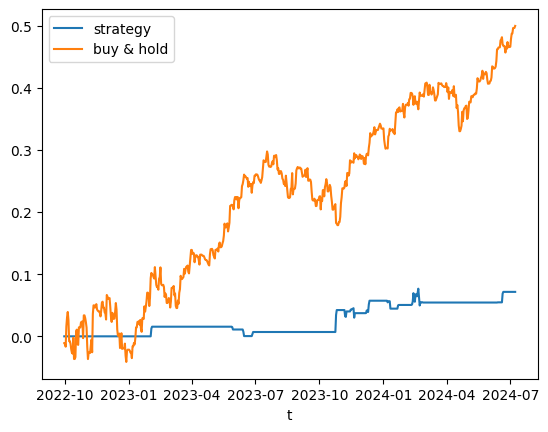

In [34]:
# Calculate statistics on test data:
stats = statistics_calc(eq[features.index[validation_split_idx]:], bh[features.index[validation_split_idx]:], plot = True)

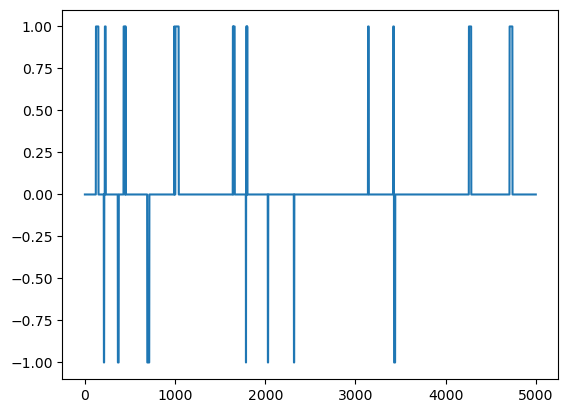

In [ ]:
plt.plot(np.arange(5000), features['position'][-5000:])

In [ ]:
# Extract the loss values from the evals_result_ dictionary
evals_result = model.get_evals_result()
train_loss = evals_result['learn']['RMSE']
test_loss = evals_result['validation']['RMSE']

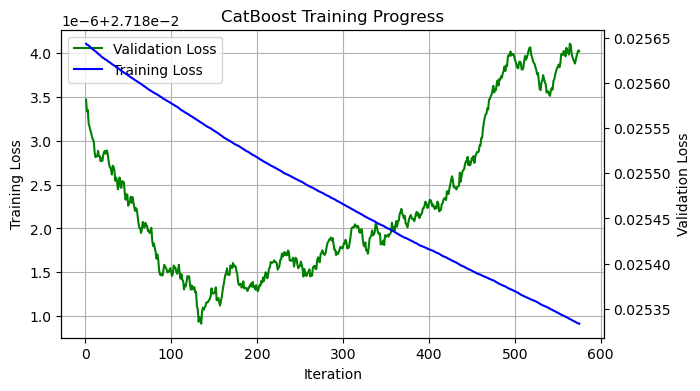

In [ ]:
# Plot the training progress
iterations = np.arange(1, len(train_loss) + 1)

fig, ax1 = plt.subplots(figsize = (7, 4) )

line1 = ax1.plot(iterations, test_loss, label = 'Validation Loss', color = 'green')

ax2 = ax1.twinx()

color = 'tab:green'
ax2.set_ylabel('Validation Loss')
line2 = ax2.plot(iterations, train_loss, label = 'Training Loss', color = 'blue')

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Training Loss')
ax1.set_title('CatBoost Training Progress')

# Make a curves list to access the parameters in the curves
lines = line1 + line2

# Add legend via axes1 or axex 2 object.
labs = [line.get_label() for line in lines]
ax1.legend(lines, labs, loc = 0)

ax1.grid()

Additional exercises and research topics:

Improve the strategy by feature engineering and using other regression models. Try other formulas for the target position calculation. Conduct detailed testing on various instruments using the walk-forward approach and stability analysis.